In [4]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt

# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
from matplotlib.ticker import LogLocator
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)


## 퀀트함수
from quant_functions import anal_funcs, data_funcs
import myfuncs
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

In [5]:
## 색 설정
color_basic = "#323232" # 기본색(글자색)
color_around = "#6E6E6E" # 회색 주변색
color_around2 = "#E0E0E0" # 밝은 회색 주변색

color_norm = "#F23557" # 강조색(진홍색)
color_norm2 = "#A60A28" # 강조색 어두움(적갈색)
color_norm3 = "#F9A5B5" # 강조색 밝음(연분홍색)

color_cont = "#22b2da" # 대비색(청록색)
color_cont2 = "#146A82" # 대비색 어두움(진청록색)
color_cont3 = "#76D1EA" # 대비색 밝음(밝은 청록색)

color_sub = "#FFA305" # 부강조색(노란색)
color_sub2 = "#9C6400" # 부강조색 어두움(갈색)
color_sub3 = "#FFCB6D" # 부강조색 밝음(연한 노란색)

## figure size 설정
figsize=(12, 8)

In [6]:
# 블루 - 퍼플 테마
colors = [color_cont, color_cont2, color_cont3]
# LinearSegmentedColormap 생성
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

#### Data

In [7]:
dm_path = "C:/Users/sdjhs/git/data/DM"
## gold = pd.read_csv(f"{dm_path}/gold.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Gold'})
gold = pd.read_csv(f"gold.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Gold'})
gold.index = pd.to_datetime(gold.index)

df_ori = data_funcs.get_merged_df('^IXIC', '^GSPC', 'SCHD', 'QQQ', 'SPY', 'GC=F', 'TLT', '^DJI')
DGS20 = fred.get_series('DGS20')
DGS10 = fred.get_series('DGS10')
df_ori = df_ori.fillna(method = 'pad')
df_ori['Gold'] = gold['Gold']
df_ori['DGS10'] = DGS10
df_ori['DGS20'] = DGS20

df_ori = df_ori[['SCHD', 'QQQ', 'SPY', '^GSPC', '^DJI', '^IXIC', 'TLT', 'DGS10', 'DGS20', 'Gold', 'GC=F']]
df_ori.columns = ['SCHD', 'QQQ', 'SPY', 'S&P500', 'DowJones', 'NASDAQ', 'TLT', 'DGS10', 'DGS20', 'Gold', 'GC=F']

[*********************100%%**********************]  8 of 8 completed


In [8]:
## Imputation
df_imputed = myfuncs.imputation(df_ori, 'S&P500', 'SPY')
df_imputed = myfuncs.imputation(df_imputed, 'S&P500', 'NASDAQ')
df_imputed = myfuncs.imputation(df_imputed, 'NASDAQ', 'QQQ')
df_imputed = myfuncs.imputation(df_imputed, 'S&P500', 'DowJones')
df_imputed = myfuncs.imputation(df_imputed, 'DowJones', 'SCHD')
df_imputed = myfuncs.imputation(df_imputed, 'DGS10', 'DGS20')
df_imputed = myfuncs.imputation(df_imputed, 'DGS20', 'TLT')
df_imputed = myfuncs.imputation(df_imputed, 'GC=F', 'Gold')
dataset = df_imputed['1970':][['SCHD', 'QQQ', 'SPY', 'TLT', 'Gold']]
dataset = dataset.fillna(method='pad')
dataset['Gold'][:gold.index[0]] = np.nan
dataset['Gold']['1975-01-02'] = 1
dataset['Gold']['1975-01-03'] = 1

0.993782918412453
0.9950001651993288
1.0456154635533108
0.919061995687683
0.8929776356463083
0.7566043664164414
-0.41911434764501393
0.9953455805075565


In [9]:
shock_dict = {"세계전충격_t0":'1948-11-01', "세계전충격_t1":'1949-10-28',
              "한국전충격_t0":'1953-07-01', "한국전충격_t1":'1954-05-28',
              "아이젠하워리세션_t0":'1957-08-01', "아이젠하워리세션_t1":'1958-04-28',
              "연착륙_t0":'1960-04-01', "연착륙_t1":'1961-02-28',
              "달러위기_t0":'1969-12-01', "달러위기_t1":'1970-10-29',
              "1차오일쇼크_t0":'1973-11-05', "1차오일쇼크_t1":'1975-03-03',
              "2차오일쇼크_t0":'1980-01-02', "2차오일쇼크_t1":'1980-07-02',
              "물가충격_t0":'1981-07-01', "물가충격_t1":'1982-11-03',
              "걸프전_t0":'1990-07-05', "걸프전_t1":'1991-03-01',
              "닷컴버블_t0":'2001-03-02', "닷컴버블_t1":'2001-11-02',
              "금융위기_t0":'2007-12-04', "금융위기_t1":'2009-06-01',
              "코로나_t0":'2020-01-31', "코로나_t1":'2020-04-03'}

In [10]:
assets = ['QQQ', 'TLT', 'Gold']

In [11]:
df = dataset[assets].copy()
df_1_0 = df[:'1984-12-31']
df_1_0 = df_1_0/df_1_0.iloc[0] * 100
## 1975년 이전 과거 금시세 참고
## https://www.macrotrends.net/1333/historical-gold-prices-100-year-chart

df = dataset[assets]['1975-01-02':].copy()
df = df/df.iloc[0] * 100
df_1 = df[:'1984-12-31']
df_1 = df_1/df_1.iloc[0] * 100
df_2 = df['1985-1-1':'1994-12-31']
df_2 = df_2/df_2.iloc[0] * 100
df_3 = df['1995-1-1':'2004-12-31']
df_3 = df_3/df_3.iloc[0] * 100
df_4 = df['2005-1-1':'2014-12-31']
df_4 = df_4/df_4.iloc[0] * 100
df_5 = df['2015-1-1':]
df_5 = df_5/df_5.iloc[0] * 100

In [12]:
#### Anualized Return

In [13]:
## AGR 그래프
def agr_plot(df):
    data = df.copy()
    ## 연간 수익률 계산
    data = myfuncs.calc_agr(data)
    ## 채권수익률 데이터 추가
    temp = df_imputed[['DGS10']].fillna(method='pad').copy()
    temp['year'] = temp.index.year
    temp = temp.groupby('year')[['DGS10']].mean()
    data['GS10'] = temp['DGS10'].copy()
    data = data[['GS10', 'S&P500']].rename(columns={'S&P500':'return'}).dropna()
    data['return'] = data['return'] * 100
    data.index = pd.to_datetime(data.index, format='%Y')

    fig, ax1 = plt.subplots(figsize=figsize)

    # GS10 데이터만 그리기
    ax1.plot(data.index, data['GS10'], color=color_cont3, label="GS10")
    ax1.set_xlabel("")
    ax1.set_ylabel("Yield", fontsize=14, fontweight="bold", color=color_around)
    ax1.set_ylim([-20, 20])
    ax1.set_xlim([min(data.index) - dt.timedelta(days=200),
            max(data.index) + dt.timedelta(days=200)])

    plt.gca().yaxis.set_major_formatter(FuncFormatter(myfuncs.percent_formatter))
    plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정
    plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

    # Return 데이터를 bar로 그리기
    ax2 = ax1.twinx()
    performance_plus = data['return'][data['return'] >= 0]
    ax2.bar(performance_plus.index, performance_plus,
            color=color_norm, alpha=1, width=150, label="Growth(positive)")
    performance_minus = data['return'][data['return'] < 0]
    ax2.bar(performance_minus.index, performance_minus,
            color=color_cont, alpha=1, width=150, label="Growth(negative)")
    ax2.axhline(0, color=color_around, linestyle='--', linewidth=2)
    ax2.set_ylabel("Growth", fontsize=14, fontweight="bold", color=color_around)
    ax2.set_ylim([-60, 100])

    plt.gca().yaxis.set_major_formatter(FuncFormatter(myfuncs.percent_formatter))
    plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정
    plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

    plt.title(f"Annual Growth Rate ({data.index.year[0]}~{data.index.year[-1]})", fontsize=22, fontweight='bold', color=color_basic)
    handler1, label1 = ax1.get_legend_handles_labels()
    handler2, label2 = ax2.get_legend_handles_labels()
    ax2.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

    ## 경기침체
    ax1.axvspan(shock_dict['1차오일쇼크_t0'], shock_dict['1차오일쇼크_t1'], facecolor=color_around, alpha=0.45)
    ax1.axvspan(shock_dict['2차오일쇼크_t0'], shock_dict['2차오일쇼크_t1'], facecolor=color_around, alpha=0.45)
    ax1.axvspan(shock_dict['물가충격_t0'], shock_dict['물가충격_t1'], facecolor=color_around, alpha=0.45)
    ax1.axvspan(shock_dict['걸프전_t0'], shock_dict['걸프전_t1'], facecolor=color_around, alpha=0.45)
    ax1.axvspan(shock_dict['닷컴버블_t0'], shock_dict['닷컴버블_t1'], facecolor=color_around, alpha=0.45)
    ax1.axvspan(shock_dict['금융위기_t0'], shock_dict['금융위기_t1'], facecolor=color_around, alpha=0.45)
    ax1.axvspan(shock_dict['코로나_t0'], shock_dict['코로나_t1'], facecolor=color_around, alpha=0.45)

    plt.tight_layout()
    plt.show()

In [14]:
## agr_plot(df_1)

In [15]:
#### Trend

In [16]:
## 트랜드 그래프
def trend_plot(df):
    data = df[assets].copy()
    _df = data.reset_index()
    _df = _df.melt(id_vars='Date', value_vars=_df.columns, var_name='Ticker', value_name='Value')

    colors = [color_norm, color_cont, color_sub]
    lineplot = sns.lineplot(data=_df, x='Date', y='Value', hue='Ticker', palette=colors, linestyle='-', linewidth=1)
    plt.title(f'Trends of {", ".join(assets)} ({data.index[0].year}~{data.index[-1].year})', fontsize=22, fontweight='bold', color=color_basic)
    plt.ylabel(f"{data.index[0].year}Y=100", fontsize=14, labelpad=-40, fontweight="bold", color=color_around, loc="top", rotation=0)
    plt.xlabel("")
    plt.xticks(fontsize=12, color=color_around)
    plt.yticks(fontsize=12, color=color_around)

    # 눈금과 축 간격 줄이기
    plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

    # 그리드 추가
    plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

    x_min, x_max = data.index.min(), data.index.max()
    # 강조할 기간 목록
    highlight_periods = [
        ('1980-01-02', '1980-07-02'),
        ('1981-07-01', '1982-11-03'),
        ('1990-07-05', '1991-03-01'),
        ('2001-03-02', '2001-11-02'),
        ('2007-12-04', '2009-06-01'),
        ('2020-01-31', '2020-04-03')
    ]

    for start, end in highlight_periods:
        # datetime으로 변환
        start_date = pd.to_datetime(start)
        end_date = pd.to_datetime(end)
        
        # x축 범위와 비교하여 범위를 조정
        if start_date > x_max or end_date < x_min:
            continue  # x축 범위를 벗어나면 건너뜀
        adjusted_start = max(start_date, x_min)
        adjusted_end = min(end_date, x_max)
        plt.axvspan(adjusted_start, adjusted_end, facecolor=color_around, alpha=0.45)

    # 그래프 표시
    plt.tight_layout()
    plt.show()

In [17]:
## trend_plot(df_1)

In [18]:
#### MDD

In [19]:
## 전고점대비 최대낙폭(MDD)
def mdd_plot(df):
    mdd_df, hrr_df = anal_funcs.get_MDD_report(df, 'a')
    hrr_df = hrr_df*100

    data = hrr_df.copy()

    colors = [color_norm, color_cont, color_sub]  # 각 그래프에 사용할 색상
    colors_edge = [color_norm2, color_cont2, color_sub2]  # 각 그래프에 사용할 색상
    # 서브플롯 생성
    fig, axes = plt.subplots(1, len(assets), figsize=(12, 4), sharey=True)  # 가로 방향 서브플롯

    for i, asset in enumerate(assets):
        # 데이터 전처리
        _df = data[[asset]].dropna().reset_index()
        _df = _df.melt(id_vars='Date', value_vars=_df.columns, var_name='Ticker', value_name='Value')

        # 현재 서브플롯 선택
        ax = axes[i]
        
        # 라인 플롯
        sns.lineplot(data=_df, x='Date', y='Value', hue='Ticker', palette=[colors[i]], linestyle='-', linewidth=1, ax=ax)
        
        # 제목 및 축 설정
        ax.set_title(f'Drawdown of {asset} ({data.index[0].year}~{data.index[-1].year})', fontsize=14, fontweight='bold', color=color_basic)
        ax.set_ylabel("MDD", fontsize=12, labelpad=-20, fontweight="bold", color=color_around, rotation=0, loc="top")
        ax.set_xlabel("")
        ax.tick_params(axis="x", labelsize=10, colors=color_around)
        ax.tick_params(axis="y", labelsize=10, colors=color_around)
        
        # y축에 퍼센트 포맷 적용
        ax.yaxis.set_major_formatter(FuncFormatter(myfuncs.percent_formatter))
        
        # 그리드 추가
        ax.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)
        
        # mdd 지점
        ax.scatter(hrr_df[asset].idxmin(), hrr_df[asset].min(), color=colors_edge[i], s=50, zorder=5)
        print(hrr_df[asset].idxmin(), hrr_df[asset].min())
        
        # 강조 영역 추가
        highlight_periods = [
            ('1980-01-02', '1980-07-02'),
            ('1981-07-01', '1982-11-03'),
            ('1990-07-05', '1991-03-01'),
            ('2001-03-02', '2001-11-02'),
            ('2007-12-04', '2009-06-01'),
            ('2020-01-31', '2020-04-03')
        ]
        for start, end in highlight_periods:
            start_date = pd.to_datetime(start)
            end_date = pd.to_datetime(end)
            if start_date > _df['Date'].max() or end_date < _df['Date'].min():
                continue
            adjusted_start = max(start_date, _df['Date'].min())
            adjusted_end = min(end_date, _df['Date'].max())
            ax.axvspan(adjusted_start, adjusted_end, facecolor=color_around, alpha=0.45)

    # 레이아웃 조정 및 표시
    plt.tight_layout()
    plt.show()

1984-07-25 00:00:00 -32.6730765132915
1981-09-30 00:00:00 -28.78705001632045
1982-06-22 00:00:00 -62.512242306994736


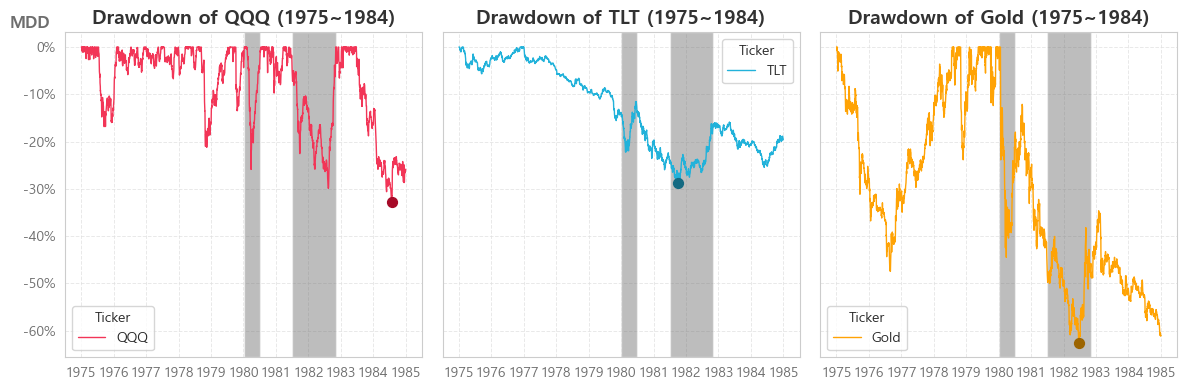

In [21]:
mdd_plot(df_1)

In [129]:
#### Rolling-Return Trend

In [130]:
def get_rr_df(df):
    data = df.resample('M').last()
    dfs = myfuncs.split_time_series(data, 12*5)
    ## calculate Rolling Returns
    _ls = []
    _idx = []
    for _df in dfs:
        _ls.append([anal_funcs.cal_YRR(_df, col, method ='a', unit = 'monthly') for col in _df.columns])
        _idx.append(_df.index[0])  
    res = pd.DataFrame(_ls, columns = _df.columns, index=_idx)
    return res

In [131]:
def rr_trend_plot(rr_df):
    _df = rr_df[assets].copy().reset_index()
    _df = _df.melt(id_vars='index', value_vars=_df.columns, var_name='Ticker', value_name='Value').rename(columns={'index':'Date'})

    plt.figure(figsize=figsize)
    colors = [color_norm, color_cont, color_sub]
    lineplot = sns.lineplot(data=_df, x='Date', y='Value', hue='Ticker', palette=colors, linestyle='-', linewidth=2)
    plt.title(f'Trends of 5Y Rolling Returns ({rr_df.index[0].year}~{rr_df.index[-1].year})', fontsize=22, fontweight='bold', color=color_basic)
    plt.ylabel("Return", fontsize=14, labelpad=-40, fontweight="bold", color=color_around, loc="top", rotation=0)
    plt.xlabel("")
    plt.xticks(fontsize=12, color=color_around)
    plt.yticks(fontsize=12, color=color_around)


    # % 단위를 추가하는 포맷터 함수 정의
    def percent_formatter(x, pos):
        return f"{int(x)}%"
    # X축, Y축에 % 포맷터 적용
    plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    # 눈금과 축 간격 줄이기
    plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

    # 그리드 추가
    plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

    # 강조 영역 추가
    highlight_periods = [
        ('1980-01-02', '1980-07-02'),
        ('1981-07-01', '1982-11-03'),
        ('1990-07-05', '1991-03-01'),
        ('2001-03-02', '2001-11-02'),
        ('2007-12-04', '2009-06-01'),
        ('2020-01-31', '2020-04-03')
    ]
    for start, end in highlight_periods:
        start_date = pd.to_datetime(start)
        end_date = pd.to_datetime(end)
        if start_date > _df['Date'].max() or end_date < _df['Date'].min():
            continue
        adjusted_start = max(start_date, _df['Date'].min())
        adjusted_end = min(end_date, _df['Date'].max())
        plt.axvspan(adjusted_start, adjusted_end, facecolor=color_around, alpha=0.45)

    # 그래프 표시
    plt.tight_layout()
    plt.show()

In [132]:
#### Rolling-Return Valiation

In [ ]:
def rr_box_plot(rr_df):
    plot_df = rr_df[assets].copy()

    plt.figure(figsize=figsize)
    colors = [color_norm, color_cont, color_sub]
    boxplot = sns.boxplot(data=plot_df, palette=colors, width=0.5, linewidth=1, linecolor= color_basic, boxprops=dict(edgecolor="black", linewidth=0))

    # 각 요소의 강조
    plt.title(f'Distribution of 5Y Rolling Returns ({rr_df.index[0].year}~{rr_df.index[-1].year})', fontsize=22, fontweight='bold', color=color_basic)
    plt.ylabel("Return", fontsize=14, labelpad=-40, fontweight="bold", color=color_around, loc="top", rotation=0)
    plt.xlabel("")
    plt.xticks(fontsize=12, color=color_around)
    plt.yticks(fontsize=12, color=color_around)


    # 상자 위에 중앙값 추가
    medians = plot_df.median()
    for i, median in enumerate(medians):
        plt.text(i, median+0.25, f'{median:.2f}%', ha='center', va="center", fontsize=11,
                color="white", fontweight="bold")


    # % 단위를 추가하는 포맷터 함수 정의
    def percent_formatter(x, pos):
        return f"{int(x)}%"
    # X축, Y축에 % 포맷터 적용
    plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    # 눈금과 축 간격 줄이기
    plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

    # 그리드 추가
    plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

    # 보조선 추가
    plt.axhline(y=0, color='lightcoral', linestyle='--', linewidth=1)

    # 그래프 표시
    plt.tight_layout()
    plt.show()

In [134]:
## rr_df = get_rr_df(df)

In [135]:
## rr_trend_plot(rr_df)

In [136]:
## rr_box_plot(rr_df)

In [137]:
#### Risk-Return Profile

In [138]:
ticker_A = 'QQQ'
ticker_B = 'TLT'

In [139]:
data = df[[ticker_A, ticker_B]].resample('M').last().dropna()
data = data/data.iloc[0]

## data-split
data_ls = myfuncs.split_time_series(data, 5*12)

## calculate Rolling Returns
return_ls = []
ddr_ls = []
_idx = []
for _data in data_ls:
    _data = myfuncs.simulate_portfolio_assets(_data.pct_change().fillna(0), [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
    _data.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]
    return_ls.append([anal_funcs.cal_YRR(_data, col, method ='a', unit = 'monthly') for col in _data.columns])
    ddr_ls.append([anal_funcs.cal_drawdown_risk(_data, col) for col in _data.columns])
    _idx.append(_data.index[0])  
    
return_data = pd.DataFrame(return_ls, columns = _data.columns, index=_idx)
ddr_data = pd.DataFrame(ddr_ls, columns = _data.columns, index=_idx)

sort_data = pd.DataFrame([return_data.mean(), ddr_data.mean()], index=['Return', 'Risk']).T
sort_data['Sortino Ratio'] = (sort_data['Return'])/sort_data['Risk']

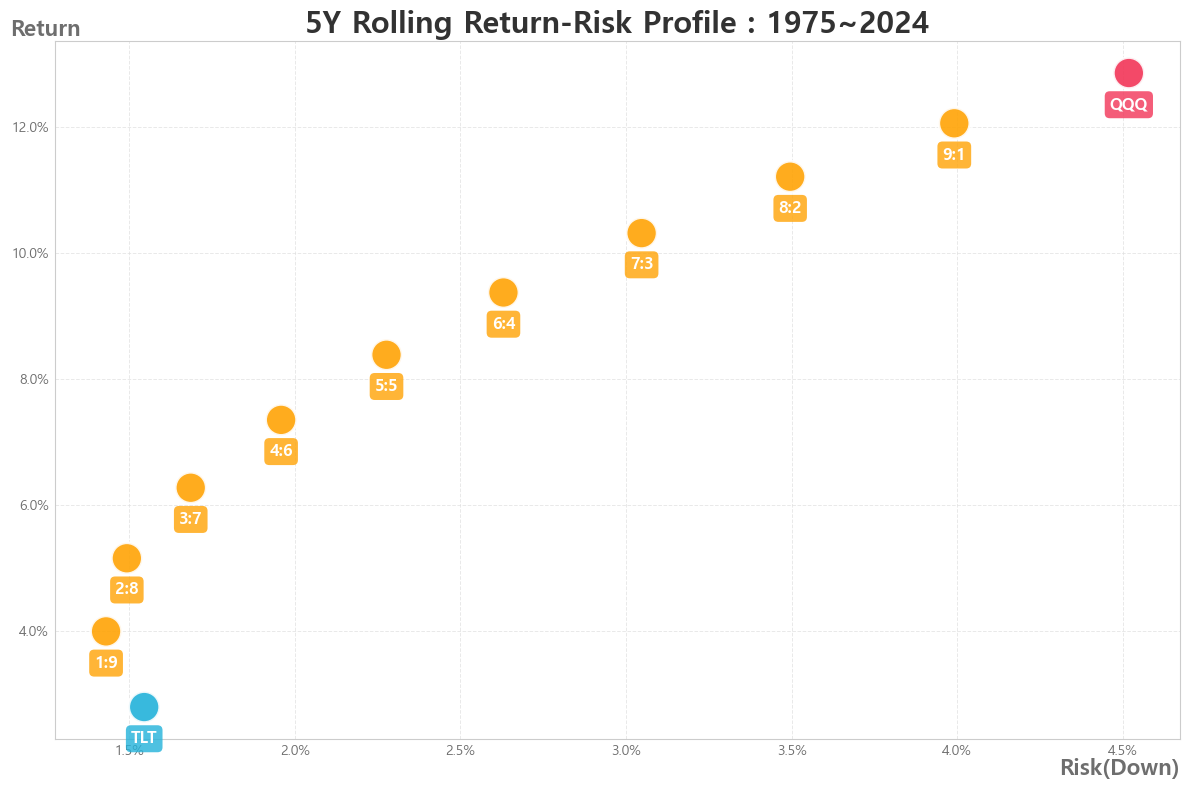

In [140]:
plot_df = sort_data.copy()

# 색상 및 크기 설정
colors = [color_norm, color_sub, color_sub, color_sub, color_sub, color_sub, color_sub, color_sub, color_sub, color_sub, color_cont]
sizes = 500

# 그래프 설정
fig, ax = plt.subplots(figsize=figsize)

# 점 그리기
x = plot_df['Risk']
y = plot_df['Return']
scatter = ax.scatter(x, y, c=colors, s=sizes, edgecolors="white", linewidth=2, alpha=0.9)


# 데이터 레이블 추가
labels = list(plot_df.index)
for i, label in enumerate(labels):
    plt.text(
        x[i], y[i]-np.abs(y.max()-y.min())*0.05, label, fontsize=12, ha="center", va="center", 
        color="white", fontweight="bold", bbox=dict(facecolor=colors[i], edgecolor='none', alpha=0.8, boxstyle="round,pad=0.3")
    )

# % 단위를 추가하는 포맷터 함수 정의
def percent_formatter(x, pos):
    return f"{round(x, 2)}%"

# X축, Y축에 % 포맷터 적용
plt.gca().xaxis.set_major_formatter(FuncFormatter(percent_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
# 눈금과 축 간격 줄이기
plt.gca().tick_params(axis="x", pad=1)  # X축 눈금 패딩 조정
plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

# 축 설정
plt.title(f"5Y Rolling Return-Risk Profile : {data.index[0].year}~{data.index[-1].year}", fontsize=22, fontweight="bold", color=color_basic)
plt.xlabel("Risk(Down)", fontsize=16, labelpad=0, fontweight="bold", color=color_around, loc="right")
plt.ylabel("Return", fontsize=16, labelpad=-50, fontweight="bold", color=color_around, loc="top", rotation=0)
plt.xticks(fontsize=10, color=color_around)
plt.yticks(fontsize=10, color=color_around)
# plt.xlim(2.9, 5.7)
# plt.ylim(2.4, 6.9)
plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

# 저장 및 출력
plt.tight_layout()
plt.show()